In [1]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
# Activate auto reload 
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# import libraries
import os
import pandas as pd
from ipywidgets import fixed, interact_manual, widgets
from ipywidgets import VBox
from IPython.display import clear_output
from IPython.display import display
from ipywidgets import Output
import matplotlib.colors as mcolors
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, share_variables, ion_selection
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.data_tools import data_tools, dataset_path_qt
from pyccapt.calibration.reconstructions import reconstruction

In [2]:
button = widgets.Button(
    description='load dataset',
)
@button.on_click
def open_file_on_click(b):
    """
    Event handler for button click event.
    Prompts the user to select a dataset file and stores the selected file path in the global variable dataset_path.
    """
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [22]:
button_r = widgets.Button(
    description='load range dataset',
)
@button_r.on_click
def open_file_on_click_r(b):
    """
    Event handler for button click event.
    Prompts the user to select a range file and stores the selected file path in the global variable range_path.
    """
    global range_path
    range_path = dataset_path_qt.gui_fname().decode('ASCII')
button_r

Button(description='load range dataset', style=ButtonStyle())

In [13]:
tdc, pulse_mode, flightPathLength, t0_d, max_mc, det_diam = wd.dataset_instrument_specification_selection()
display(tdc, flightPathLength)

Dropdown(description='Data mode:', options=('PyCCAPT', 'leap_epos', 'leap_pos', 'ato_v6'), value='PyCCAPT')

FloatText(value=110.0, description='Flight path length:')

In [11]:
# exctract needed data from Pandas data frame as an numpy array
# create an instance of the Variables opject
variables = share_variables.Variables()
variables.pulse_mode = pulse_mode
dataset_main_path = os.path.dirname(dataset_path)
dataset_main_path = os.path.dirname(dataset_main_path)
dataset_name_with_extention = os.path.basename(dataset_path)
variables.dataset_name = os.path.splitext(dataset_name_with_extention)[0]
variables.result_data_path = dataset_main_path 
variables.result_data_name = variables.dataset_name
variables.result_path = dataset_main_path + '/visualization/'

if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
    
# Create data farame out of hdf5 file dataset
data = data_tools.load_data(dataset_path, tdc.value, mode='processed')
# extract data from the path and create the Variable object
data_tools.extract_data(data, variables, flightPathLength.value, max_mc.value)

The maximum time of flight: 5010


In [12]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse,start_counter,t_c (ns),t (ns),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,8.639271,-22.420346,4.526197,26.999754,28.556046,5018.839844,1003.768005,6860,0.0,617.933228,1.080816,-2.804898,0,0
1,-13.315262,3.781210,1.466954,27.403896,30.019277,5018.839844,1003.768005,6949,0.0,618.173279,-1.609796,0.457143,89,2
2,-10.068775,21.963494,4.578796,113.503393,126.272476,5018.839844,1003.768005,7911,0.0,1253.614990,-1.260408,2.749388,962,1
3,-13.534804,7.211387,1.805480,27.022691,29.652876,5018.839844,1003.768005,8223,0.0,616.177612,-1.642449,0.875102,312,1
4,12.235849,19.036460,3.998454,27.067992,29.081018,5018.839844,1003.768005,8328,0.0,620.703857,1.521633,2.367347,105,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10657311,2.533200,-2.602603,56.004683,26.701804,28.812703,6350.299805,1270.060059,4967,0.0,538.353027,0.238367,-0.244898,15,2
10657312,-8.158685,-13.472115,57.423538,14.057703,15.092135,6350.299805,1270.060059,4987,0.0,404.381958,-0.777143,-1.283265,20,1
10657313,-7.322665,-15.124382,57.632844,27.075017,29.215558,6350.299805,1270.060059,5041,0.0,546.850037,-0.698776,-1.443265,54,1
10657314,24.559840,14.523208,60.948283,27.203200,28.946840,6350.299805,1270.060059,5094,0.0,555.161987,2.413061,1.426939,53,1


In [24]:
if 'range_path' in locals():
    variables.range_data = data_tools.read_hdf5_through_pandas(range_path)

else:
    variables.range_data = pd.DataFrame({"ion": ['unranged'], "mass": [0], "mc": [0], "mass": [0], "mc_low": min(variables.mc_calib), "mc_up": max(variables.mc_calib), "color": ['#000000'], "element": ['unranged'],
                                        "complex": [0], "isotop": [0], "charge": [0]})

if variables.range_data.empty:
    element_percentage = str([0.01])
else:
    element_percentage = [0.01] * len(variables.range_data['element'].tolist())
    element_percentage = str(element_percentage)
    
display(variables.range_data.style.applymap(ion_selection.display_color, subset=['color']))


,ion,mass,mc,mc_low,mc_up,color,peak_count,element,complex,isotope,charge
0,${}^{1}H^{+}$,1.010000,1.061654,0.919950,1.184933,#b2aa2d,3012,H,1,1,1
1,${}^{27}Al^{2+}$,13.490000,13.473593,13.911091,15.661570,#e7e0d1,308876,Al,1,27,2
2,${}^{27}Al^{+}$,26.980000,26.986591,27.991873,31.524390,#e7e0d1,3471638,Al,1,27,1


In [25]:
change_color = widgets.Button(
    description='change color',
)
color_picker = widgets.ColorPicker(description='Select a color:')
row_index = widgets.IntText(value=0, description='index row:')
@change_color.on_click
def change_color_m(b,):
    with out:
        selected_color = mcolors.to_hex(color_picker.value)
        variables.range_data.at[row_index.value, 'color'] = selected_color
        clear_output(True)
        display(variables.range_data.style.applymap(ion_selection.display_color, subset=['color']))
        
# Create a container for the widgets
container = widgets.VBox([color_picker, row_index, change_color])
out = Output()
# Display the widgets
display(container, out)

Output()

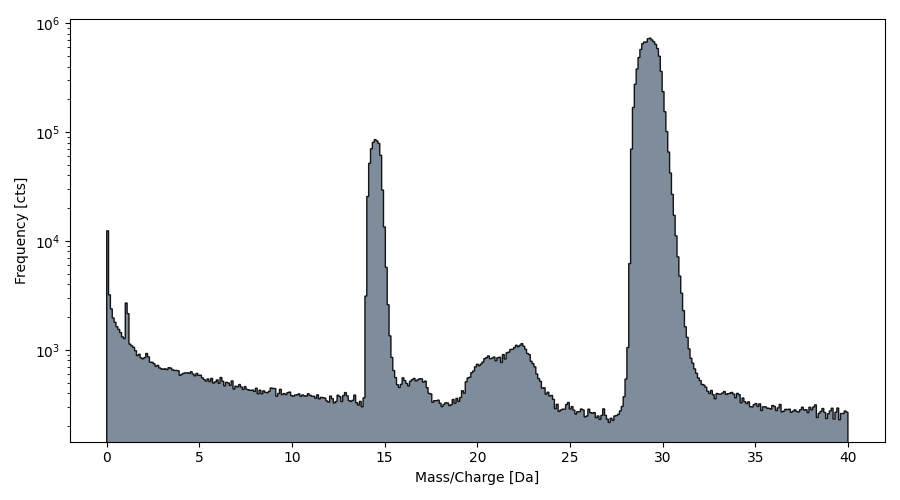

The peak index for MRP calculation is: 4


In [47]:
from pyccapt.calibration.calibration_tools import mc_plot

mc_hist = mc_plot.AptHistPlotter(variables.mc_calib[variables.mc_calib < 40], variables)
mc_hist.plot_histogram(bin_width=0.1, label='mc', log=True, fig_size=(9, 5))
mc_hist.find_peaks_and_widths(prominence=100, distance=10, percent=50)
mc_hist.plot_peaks()
mc_hist.plot_hist_info_legend(label='mc', bin=0.1, background=None, loc='right')
mc_hist.adjust_labels()
mc_hist.selector(selector='peak') # rect, peak, range
mc_hist.save_fig(label='mc', fig_name='mc')
# mc_hist.plot_range(range_data=variables.range_data, legend=True)
# plot_color_legend(loc='upper right')

# mc_hist.plot_background(mode, non_peaks=None, lam=5e10, tol=1e-1, max_iter=100, num_std=3, poly_order=5, plot_no_back=True, plot=True, patch=True) #mode = aspls, fabc, dietrich, cwt_br, selective_mask_t, 

$$\textbf{You can specify which dataset to use in below block}$$

In [26]:
def mc_hist_plot(bin_size, lim_mc, peaks_find, ranging, hist_color_range, figname):
    peaks_ini, peaks_y_ini, peak_widths_p_ini, _ = tools.hist_plot(variables.mc_c[variables.mc_c < lim_mc], variables, bin=bin_size, range_data=variables.range_data, ranging=ranging, hist_color_range=hist_color_range, adjust_label=False, peaks_find=peaks_find, peaks_find_plot=True, plot=True, label='mc', fig_name=figname)
   
interact_manual(mc_hist_plot, bin_size=widgets.FloatText(value=0.1), lim_mc=widgets.IntText(value=400), ranging=widgets.Dropdown(options=[('False', False),('True', True)]),
                peaks_find=widgets.Dropdown(options=[('True', True), ('False', False)]),
                hist_color_range=widgets.Dropdown(options=[('True', True), ('False', False)])
                , figname=widgets.Text(value='mc'));

interactive(children=(FloatText(value=0.1, description='bin_size'), IntText(value=400, description='lim_mc'), …

In [12]:
plot_3d_button = widgets.Button(
    description='plot 3D',
)
plot_heatmap_button = widgets.Button(
    description='plot heatmap',
)
plot_mc_button = widgets.Button(
    description='plot mc',
)
plot_projection_button = widgets.Button(
    description='plot projection',
)

clear_button = widgets.Button(
    description='Clear plots',
)

figname_3d=widgets.Text(value='3d_plot', description='fig name')
selected_area_p3=widgets.Dropdown(options=[('False', False), ('True', True)], description='Selected area')
rotary_fig_save_p3=widgets.Dropdown(options=[('True', True), ('False', False)], description='Rotary save')
element_percentage_p3=widgets.Textarea(value=element_percentage, description='Element percentage')
@plot_3d_button.on_click
def plot_3d(b):
    with out:
        if selected_area_p3.value:
            variables.selected_z1 = variables.selected_y1
            variables.selected_z2 = variables.selected_y2
            variables.selected_y1 = variables.selected_x1
            variables.selected_y2 = variables.selected_x2
            print('Min x (nm):', variables.selected_x1, 'Max x (nm):', variables.selected_x2)
            print('Min y (nm):', variables.selected_y1, 'Max y (nm):', variables.selected_y2)
            print('Min z (nm):', variables.selected_z1, 'Max z (nm):', variables.selected_z2)
        reconstruction.reconstruction_plot(variables, element_percentage_p3.value, rotary_fig_save_p3.value, selected_area_p3.value, figname_3d.value)

selected_area_ph=widgets.Dropdown(options=[('False', False), ('True', True)], description='Selected area')
element_percentage_ph=widgets.Textarea(value=element_percentage, description='Element percentage')
figname_heatmap=widgets.Text(value='heatmap', description='fig name')
@plot_heatmap_button.on_click
def plot_heatmap(b, variables=variables):
    with out:
        if selected_area_ph.value:
            variables.selected_z1 = variables.selected_y1
            variables.selected_z2 = variables.selected_y2
            variables.selected_y1 = variables.selected_x1
            variables.selected_y2 = variables.selected_x2
            print('Min x (nm):', variables.selected_x1, 'Max x (nm):', variables.selected_x2)
            print('Min y (nm):', variables.selected_y1, 'Max y (nm):', variables.selected_y2)
            print('Min z (nm):', variables.selected_z1, 'Max z (nm):', variables.selected_z2)

        reconstruction.heatmap(variables, selected_area_ph.value, element_percentage_ph.value, save=True)

selected_area_pm=widgets.Dropdown(options=[('False', False), ('True', True)], description='Selected area')
peak_find_plot=widgets.Dropdown(options=[('False', False), ('True', True)], description='peak find')
rangging=widgets.Dropdown(options=[('False', False), ('True', True)], description='rangging')
range_file_exist_pm=widgets.Dropdown(options=[('True', True), ('False', False)], description='Range exist')
bin_size_pm = widgets.FloatText(value=0.1, description='Bins size')
lim_mc_pm = widgets.IntText(value=150, description='Limit mc')
hist_color_range=widgets.Dropdown(options=[('True', True), ('False', False)], description='hist color')
figname_mc=widgets.Text(value='mc', description='fig name')
@plot_mc_button.on_click
def plot_mc(b,):
    with out:
        if selected_area_pm.value:
            variables.selected_z1 = variables.selected_y1
            variables.selected_z2 = variables.selected_y2
            variables.selected_y1 = variables.selected_x1
            variables.selected_y2 = variables.selected_x2
            print('Min x (nm):', variables.selected_x1, 'Max x (nm):', variables.selected_x2)
            print('Min y (nm):', variables.selected_y1, 'Max y (nm):', variables.selected_y2)
            print('Min z (nm):', variables.selected_z1, 'Max z (nm):', variables.selected_z2)

        peaks_ini, peaks_y_ini, peak_widths_p_ini, _ = tools.hist_plot(variables.mc_c[variables.mc_c < lim_mc_pm.value], variables, bin=bin_size_pm.value, range_data=variables.range_data, 
                                                               ranging=rangging.value, hist_color_range=hist_color_range.value, adjust_label=False, peaks_find=True, peaks_find_plot=peak_find_plot.value, plot=True, label='mc', fig_name=figname_mc.value)


element_percentage_pp=widgets.Textarea(value=element_percentage, description='Element percentage')
selected_area_pp=widgets.Dropdown(options=[('False', False), ('True', True)], description='Selected area')
x_or_y_pp=widgets.Dropdown(options=['x', 'y'], value='x', description='X or Y')
figname_p = widgets.Text(value='projection', description='fig name')
@plot_projection_button.on_click
def plot_projection(b,):
    with out:
        if selected_area_pp.value:
            variables.selected_z1 = variables.selected_y1
            variables.selected_z2 = variables.selected_y2
            variables.selected_y1 = variables.selected_x1
            variables.selected_y2 = variables.selected_x2
            print('Min x (nm):', variables.selected_x1, 'Max x (nm):', variables.selected_x2)
            print('Min y (nm):', variables.selected_y1, 'Max y (nm):', variables.selected_y2)
            print('Min z (nm):', variables.selected_z1, 'Max z (nm):', variables.selected_z2)

        reconstruction.projection(variables, element_percentage_pp.value, selected_area_pp.value, x_or_y_pp.value, figname_p.value)

@clear_button.on_click
def clear(b,):
    with out:
        clear_output(True)
        print('')


tab1 = VBox(children=[selected_area_pp, x_or_y_pp, element_percentage_pp, figname_p, plot_projection_button, clear_button])
tab2 = VBox(children=[selected_area_p3, rotary_fig_save_p3, element_percentage_p3, figname_3d, plot_3d_button, clear_button])
tab3 = VBox(children=[selected_area_pm, bin_size_pm, lim_mc_pm, peak_find_plot, rangging, hist_color_range, figname_mc, plot_mc_button, clear_button])
tab4 = VBox(children=[selected_area_ph, element_percentage_ph, figname_heatmap, plot_heatmap_button, clear_button])
# tab2 = VBox(children=[VBox(children=[HBox(children=[plot_3d_button, selected_area_p3, range_file_exist_p3, rotary_fig_save_p3, element_percentage_p3]),
#                                      HBox(children=[plot_heatmap_button, selected_area_ph, element_percentage_ph]),
#                                      HBox(children=[plot_mc_button, selected_area_pm, range_file_exist_pm, bin_size_pm, prominence_pm, distance_pm, lim_mc_pm, percent_pm]), 
#                                      HBox(children=[plot_projection_button, selected_area_pp, x_or_y_pp, element_percentage_pp])]), clear_button])


tab = widgets.Tab(children=[tab1, tab2, tab3, tab4])
tab.set_title(0, 'projection')
tab.set_title(1, '3d plot')
tab.set_title(2, 'mc plot')
tab.set_title(3, 'heatmap plot')



display(VBox(children=[tab]))
out = Output()
display(out)

NameError: name 'element_percentage' is not defined